## Support Vector Machines (SVM)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
sns.set()  ## use Seaborn plotting defaults

In [3]:
from sklearn.datasets.samples_generator import make_blobs

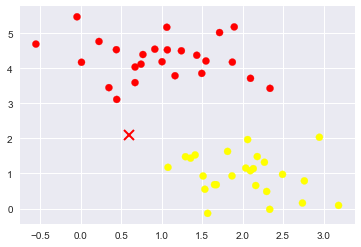

In [4]:
X,y = make_blobs(n_samples = 50, centers = 2, random_state=0, cluster_std=0.6)
plt.scatter(X[:,0], X[:,1], c=y, s= 50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth= 2, markersize=10)

In [5]:
np.linespace?

Object `np.linespace` not found.


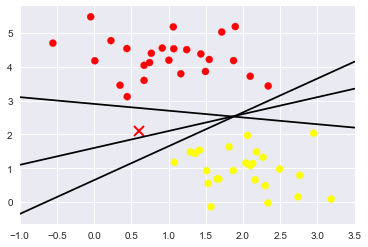

In [5]:
## there is more than one possible dividing line that can perfectly discriminate between the two classes!

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]: plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5);

### Support Vector Machines: Maximizing the Margin

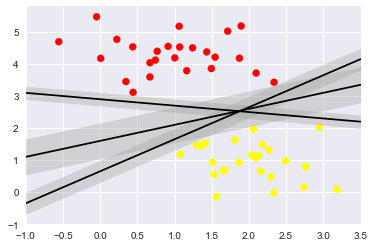

In [6]:
## Rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some 
## width, up to the nearest point.

xfit = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]: 
    yfit=m*xfit+b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA',alpha=0.4)
plt.xlim(-1, 3.5);


### Fitting a support vector machine

 Let’s see the result of an actual fit to this data: we will use Scikit-Learn’s support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number

In [7]:
from sklearn.svm import SVC ## "Support Vector Classifier"
model = SVC(kernel='linear', C= 1E10)
model.fit(X,y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

##### To better visualize what’s happening here, let’s create a quick convenience function that will plot SVM decision boundaries for us 

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    
    """Plot the decision function for a two-dimensional SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
               
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support: 
        ax.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

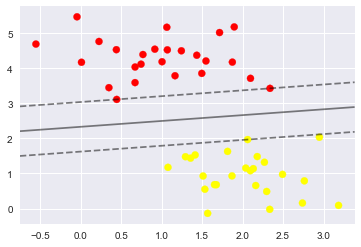

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

##### This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin; they are indicated by the black circles. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points is stored in the "support_ vectors_" attribute of the classifier

In [10]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### Beyond linear boundaries: Kernel SVM

SVM becomes extremely powerful is when it is combined with kernels. we project our data into higher-dimensional space defined by polynomials and fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for ker‐ nels, let’s look at some data that is not linearly separable

#### A linear classifier performs poorly for nonlinear boundaries

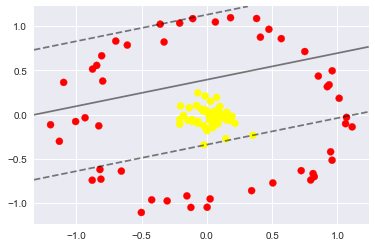

In [11]:
from sklearn.datasets.samples_generator import make_circles
X,y = make_circles(100, factor= .1, noise= .1)

clf = SVC(kernel='linear').fit(X,y)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

#### It is clear that no linear discrimination will ever be able to separate this data. But about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

#### We can visualize this extra data dimension using a three-dimensional plot

In [12]:
r = np.exp(-(X ** 2).sum(1))

In [14]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, interactive, fixed, interact_manual
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn') 
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
interact(plot_3D, elev=[-90, 180], azip=(-180, 270), X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 180), value=-90), IntSlider(value=30, description='azim', max=90, min=-30), Output()), _dom_classes=('widget-interact',))

#### We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.
#### In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.


A potential problem with this strategy— projecting N points into N dimensions—is that it might become very computationally intensive as N grows large. 

##### However, because of a neat little procedure known as the kernel trick, a fit on kernel- transformed data can be done implicitly— i.e. without ever building the full N- dimensional representation of the kernel projection! 

This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.
In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter

In [17]:
clf = SVC(kernel='rbf', C=1E6).fit(X,y)
clf

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

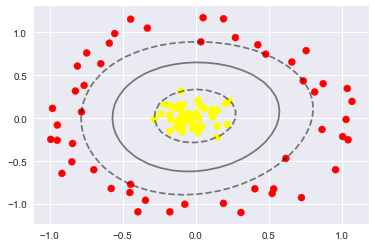

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')

### Tuning the SVM: Softening margins
#### Our discussion so far has centered on very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap?

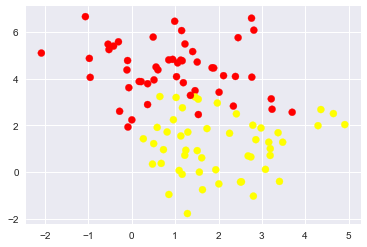

In [33]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

To handle this case, the SVM implementation has a bit of a fudge-factor that “softens” the margin; that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as C. 

##### For very large C, the margin is hard, and points cannot lie in it. For smaller C, the margin is softer, and can grow to encompass some points.

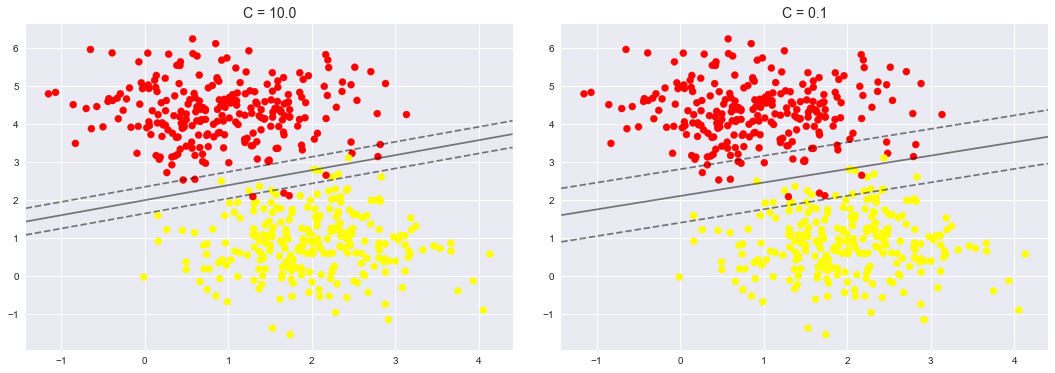

In [41]:
X, y = make_blobs(n_samples=500, centers=2,random_state=0, cluster_std=0.8)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y) 
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') 
    plot_svc_decision_function(model, axi) 
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none')
    axi.set_title('C = {0:.1f}'.format(C), size=14)


#### The optimal value of the C parameter will depend on your dataset, and should be tuned via cross-validation or a similar procedure

### Example: Face Recognition
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.

In [45]:
from sklearn.datasets import fetch_lfw_people 
faces = fetch_lfw_people(min_faces_per_person=60) 
print(faces.target_names) 
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


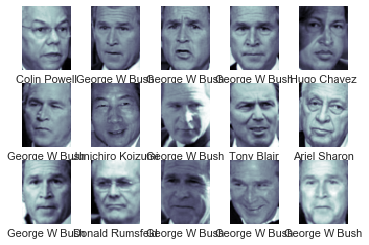

In [56]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
                axi.imshow(faces.images[i], cmap='bone')
                axi.set(xticks=[], yticks=[],
                        xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use;

##### Principal Component Analysis to extract 150 fundamental components to feed into our support vector machine classifier. 
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [58]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA 
from sklearn.pipeline import make_pipeline
            
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

/Users/FeezaMittal/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


##### For the sake of testing our classifier output, we will split the data into a training and testing set:

In [59]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

/Users/FeezaMittal/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [65]:
type(faces)

sklearn.utils.Bunch